In [ ]:
# Global/WindowsApps (3.9.13)
!pip3 install --user fredapi
!pip3 install --user matplotlib
!pip3 install --user numpy
!pip3 install --user scipy
!pip3 install --user pandas
!pip3 install --user seaborn
!pip3 install --user sklearn

In [37]:
from fredapi import Fred
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import datetime
from dateutil import relativedelta


key = os.environ.get('FRED_KEY')
fred = Fred(api_key=key)

_WINSEL_ = 30


In [38]:
def normalize(df):
    normalized_df=(df-df.min())/(df.max()-df.min())
    std_df=(df-df.mean())/df.std()
    return std_df

def dual_plot(a,b):
    fig,ax1 = plt.subplots()
    ax1.plot(a,c='darkgray')
    #ax1.set_yscale('log')
    ax2 = ax1.twinx()
    ax2.plot(b,c='goldenrod')
    plt.plot()

def get_next_month(today:datetime):
    nextmonth = today + relativedelta.relativedelta(months=1)
    return nextmonth

date_to_index = lambda x: x.astype('str')
index_to_date = lambda x: pd.to_datetime(x.index)

In [39]:
start= "2004-01-03"
end  = "2022-01-03"

indicator   = fred.get_series('T5YIFR',observation_start=start, observation_end=end)
#indicator   = fred.get_series('AMTMNO',observation_start=start, observation_end=end)
stock = fred.get_series('NASDAQ100',observation_start=start, observation_end=end)


# Dataset 생성

In [40]:
def kernel(indicator_set, stock_set, WINDOW:int):
    score = np.array([], dtype=np.float32)
    len_index = indicator_set.index
    len_index = int(len(len_index)/WINDOW)
    #print(len_index)
    for i in range(len_index):
        _indicator   = indicator_set.iloc  [WINDOW*i : WINDOW*(i+1)]
        _stock = stock_set.iloc[WINDOW*i : WINDOW*(i+1)]
        _indicator   = normalize(_indicator)
        _stock = normalize(_stock)

        df = pd.DataFrame()
        df.index = _indicator.index
        df['indicator']  = normalize(_indicator)
        df['stock'] = normalize(_stock)

        score = np.append(score, df.corr().indicator.stock)

    np.random.shuffle(score)
    score = pd.Series(score)
    mean_score = round(score.mean(),2)
    #print(mean_score)
    return normalize(score)


def split_dataset(dataset, prob:list = [0.7, 0.3]):
    _len = len(dataset)
    ptr = 0
    training_set   = dataset.iloc[:int(_len*prob[0])]
    ptr += int(_len*prob[0])
    validation_set = dataset.iloc[ptr: ptr+int(_len*prob[1])]
    return training_set, validation_set

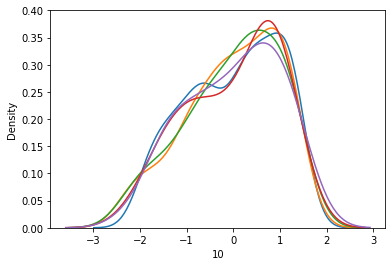

In [41]:
indicator_set, stock_set = indicator, stock

windows = [10,30,60,90,120]
scores = pd.DataFrame([])

for i,w in enumerate(windows):
    scores[str(w)] = kernel(indicator_set, stock_set, w)
    sns.kdeplot(data=scores[str(w)])

# Fit

156 109 46


<AxesSubplot:xlabel='30', ylabel='Count'>

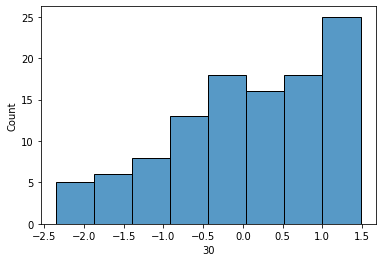

In [42]:
sel_dset = scores[str(_WINSEL_)].dropna()
training_set, validation_set = split_dataset(sel_dset)

print(len(sel_dset),len(training_set), len(validation_set))

sns.histplot(data= training_set)

In [43]:
import numpy as np
from sklearn.mixture import GaussianMixture

fit_data = training_set.values.reshape(-1,1)
GMM = GaussianMixture(n_components=2, ).fit(fit_data)

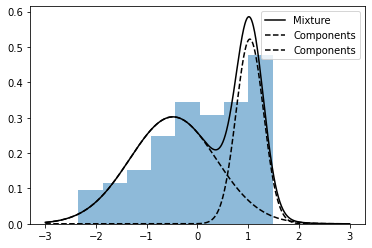

In [44]:
# plot resulting fit
x_range = np.linspace(-3, 3, 1000)

pdf = np.exp(GMM.score_samples(x_range.reshape(-1, 1)))
responsibilities = GMM.predict_proba(x_range.reshape(-1, 1))
pdf_individual = responsibilities * pdf[:, np.newaxis]

plt.hist(fit_data, bins='auto', density=True, histtype='stepfilled', alpha=0.5)
plt.plot(x_range, pdf, '-k', label='Mixture')
plt.plot(x_range, pdf_individual, '--k', label='Components')
plt.legend()
plt.show()

# Validate

In [45]:
predict =  GMM.predict_proba(validation_set.values.reshape(-1, 1))

In [46]:
np.argmax(predict,axis=1)

array([1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 1], dtype=int64)

# Predict

In [51]:
start= "2017-12-03"
end  = "2022-06-20"

test_indicator= fred.get_series('T5YIFR',observation_start=start, observation_end=end)
test_stock = fred.get_series('NASDAQ100',observation_start=start, observation_end=end)

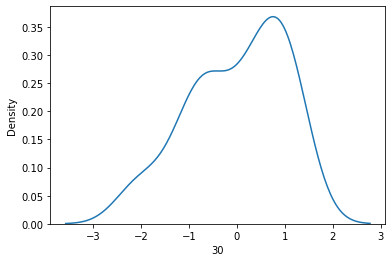

In [52]:
indicator_set, stock_set = test_indicator, test_stock

windows = [10,30,60,90,120]
scores = pd.DataFrame([])

for i,w in enumerate(windows):
    scores[str(w)] = kernel(indicator_set, stock_set, w)
    if w == _WINSEL_:
        sns.kdeplot(data=scores[str(w)])

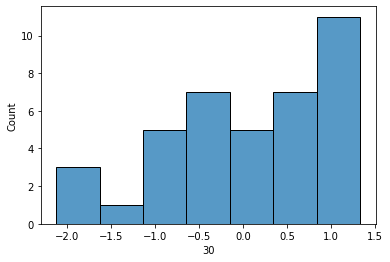

In [53]:
sel_dset = scores[str(_WINSEL_)]
sns.histplot(data= sel_dset)

test_set = sel_dset.dropna().values.reshape(-1, 1)
predict = GMM.predict_proba(test_set)
label = np.argmax(predict,axis=1)

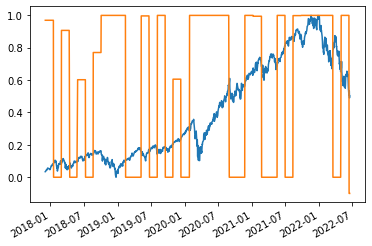

In [54]:
def _normalize(df):
    normalized_df=(df-df.min())/(df.max()-df.min())
    return normalized_df
plot_data = test_stock.dropna()
plot_data = _normalize(plot_data)
plot_data.plot()



label = np.argmax(predict,axis=1)
plot_label = np.array([])

for i in range(int(len(plot_data)/_WINSEL_)):
    plot_label = np.append(plot_label, np.ones(_WINSEL_)*label[i]*predict[i][label[i]], axis=0)
plot_label = np.append(plot_label, np.ones(int(len(plot_data)%_WINSEL_))*-0.1, axis=0)

plt.plot(plot_data.index ,plot_label)

# 결과

# 2022-06-27
* 기대인플레이션 - 나스닥100 지수를 사용함
* Training/Predict windows의 사이즈에 상관 없이 단일로는 성능이 안나옴
    * 다양한 사이즈로 composite하게 사용해보자